# TL;DR

This notebook is used to run experiments for offline data analysis section in the Aquarius paper. 

# Import & Utils

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from math import pi
import time
import datetime

from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, MinMaxScaler, RobustScaler
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split

import json
import math
import random

%matplotlib inline
min_max_scaler = preprocessing.MinMaxScaler()

sns.set(style="ticks")
sns.set_style({"xtick.direction": "in","ytick.direction": "in","xtick.top":True,"ytick.right":True,"axes.grid":True})

In [2]:
'''
write data to json file
'''
def json_write2file(data, filename):
    with open(filename, "w") as write_file:
        json.dump(data, write_file, indent=4) # w/ indent the file looks better

'''
read data from json file
'''
def json_read_file(filename):
    with open(filename, "r") as read_file:
        return json.load(read_file)
    
# @desc:   read lines from a file into a list
# @params: (str)filename
# @return: list of strings
def read_file(filename):
    lines = []
    with open (filename, "r") as myfile:
        lines = [line.rstrip('\n') for line in myfile]
    return lines

def get_page_load_time(filename, ep=None, verbose=False):
    traces = !ls {filename}
    traces = [t for t in traces if 'trace' in t]
    if ep:
        if ep == -1:
            traces = [t for t in traces if 'ep' not in t]
        else:
            traces = [t for t in traces if 'ep{}'.format(ep) in t]

    
    page_load_time = []
    page_load_time_wiki = []
    page_load_time_static = []
    n_timeout = 0
    n_reset = 0
    n_sent = 0
    n_encode = 0
    n_404 = 0
    n_closed = 0
    
    for t in traces:
        if verbose: print("parsing trace {}".format(t))
        plt_all, plt_wiki, plt_static = [], [], []
        wiki_log = read_file(os.path.join(filename, t))
        for line in wiki_log:
            _ = line.split(' ')[-1]
            if ' failed ' not in line:
                plt_all.append(float(_))
                if 'wiki/index.php' in line:
                    plt_wiki.append(float(_))
                else:
                    plt_static.append(float(_))
                
            elif '[Errno 110]' in line:
                n_timeout += 1
            elif '[Errno 104]' in line:
                n_reset += 1
            elif 'Request-sent' in line:
                n_sent +=1
            elif 'HTTP_404' in line:
                n_404 += 1
            elif "\'ascii\' codec can\'t encode" in line:
                n_encode += 1
            elif "closed connection without response" in line:
                n_closed += 1
            else:
                print(line)
        
        # log if verbose
        if verbose:
            for k, plt_ in zip(['all', 'wiki', 'static'], [plt_all, plt_wiki, plt_static]):
                plt_ = np.array(plt_)
                print("plt {}: mean - {:.4f} median - {:.4f} 99p - {:.4f}".format(k, plt_.mean(), np.median(plt_), np.percentile(plt_, 99)))
        page_load_time += plt_all
        page_load_time_wiki += plt_wiki
        page_load_time_static += plt_static

    return {
        'page_load_time': page_load_time, 
        'plt_wiki': page_load_time_wiki, 
        'plt_static': page_load_time_static, 
        'timeout': n_timeout, 
        'n_reset': n_reset,
        'n_sent': n_sent,
        'n_404': n_404
    }

In [638]:
COLORS = ["#3978af", 
          "#d1342b",
          "#559d3f",
          "#ef8532", 
          "#634295", 
          "#a65d34", 
          "#aecde1", 
          "#b4dc93",
          "#ee9e9b", 
          "#f4c07b", 
          "#c6b4d3",
          "#fffea6",
          "#df3583"
]

MARKERS = ["o", "^", "D", "P"]

trace_types = [
    'PHP For-Loop', 
    'PHP File', 
    'Wiki',
    'Wiki (Flooded)'
]

color_map = {t: COLORS[i] for i,t in enumerate(trace_types)}
marker_map = {t: MARKERS[i] for i,t in enumerate(trace_types)}

In [4]:
shm_layout = json_read_file("../../src/lb/shm_layout_base_dev.json")

feature_as_cnt = [_[1] for _ in shm_layout["vpp"]["struct"]["as_stat"][1:]] # counter features gathered for each AS in as_stat_t
feature_as_res = [_[1] for _ in shm_layout["vpp"]["struct"]["reservoir_as"]] # features gathered for each AS w/ reservoir sampling
feature_lb_res = [_[1] for _ in shm_layout["vpp"]["struct"]["reservoir_lb"]] # features gathered for LB node w/ reservoir sampling
RES_FEATURE_ENG = ["avg", "90", "std", "avg_decay", "90_decay"]
FEATURE_AS_ALL = feature_as_cnt + ["_".join((a, b)) for a in feature_as_res for b in RES_FEATURE_ENG]
# avg AS features and append LB features
FEATURE_LB_ALL = FEATURE_AS_ALL + \
    ["_".join((a, b)) for a in feature_lb_res for b in RES_FEATURE_ENG]
GT = ["cpu", "memory", "apache", "asid"]

# Table of Contents

1. Run experiments for three traces
2. Load datasets
3. Analyse correlations (section 4.1.1)
4. PCA Analysis (section 4.1.2)
5. Overhead analysis (section 4.1.3)

## Run Experiments

### Unit Test

In [323]:
import sys
utils_dir = '../../src/utils'
sys.path.insert(0, utils_dir) # add utils dir to path
import testbed_utils as tu

In [324]:
lb_method = 'ecmp'
trace='wiki_600'
experiment='atc-classification'
sample='hour12.csv'
from_orig=None
config_file_prefix='conf01'
colocate=None
colocate_freq=0.0001
twist=False
clip_n=200000

In [325]:
server_id = 1
config_file = config_file_prefix+'-'+str(server_id)
config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in [0]}
ip_remote = tu.COMMON_CONF['net']['physical_server_ip']

task_name, task_dir, nodes = tu.init_task_info(
    experiment=experiment,
    lb_method=lb_method,
    trace=trace,
    sample=sample,
    filename=config_file+'.json',
    colocate=colocate,
    colocate_freq=colocate_freq,
    alias=config_file_prefix
)

print(">> run task {}".format(task_name))

init_task_info: alias=conf01
alias=conf01
>> run task wiki_600-ecmp-hour12-conf01


In [326]:
for server_id in [0]:
    if clip_n and server_id == 0:
        clip_str = '-n {}'.format(clip_n)
    else:
        clip_str = ''
    
    cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/run2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json {}"'.format(
        ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], clip_str)
#     print(cmd)
    tu.subprocess.Popen(cmd, shell=True)

In [327]:
tu.prepare_img(lb_method=lb_method, from_orig=from_orig, debug_node=False)

Create LB node image...
Create LB node image...


In [328]:
tu.runall()
time.sleep(10)

node_lb_0 ready: ssh -p 8900 cisco@localhost
node_lb_1 ready: ssh -p 8901 cisco@localhost
node_server_0 ready: ssh -p 9000 cisco@localhost
node_server_1 ready: ssh -p 9001 cisco@localhost
node_server_2 ready: ssh -p 9002 cisco@localhost
node_server_3 ready: ssh -p 9003 cisco@localhost
node_server_4 ready: ssh -p 9004 cisco@localhost
node_server_5 ready: ssh -p 9005 cisco@localhost
node_server_6 ready: ssh -p 9006 cisco@localhost


In [329]:
net_ok = False
while not net_ok:
    try:
        tu.gt_socket_check()
        net_ok = True
    except:
        print('error')
        time.sleep(1)

LB Node 0: pass
LB Node 1: pass


In [331]:
# start gathering at LB node
for lb in tu.NODES['lb']:
    lb.run_init_bg()
# run traffic
t0 = time.time()
cmd = 'ssh -t yzy@10.60.16.12 "python3 /home/yzy/Load-Balancer/src/utils/run_traffic_flood.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
    experiment, colocate_freq, lb_method, trace, sample, config_file_remote[0])

tu.subprocess_cmd(cmd)
print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))


Trace replay over w/ total time: 400.919s


In [332]:
# fetch results from nodes
for server_id in [0]:
    cmd = 'ssh -t yzy@{} "python3 /home/yzy/Load-Balancer/src/utils/shutdown2server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
        ip_remote[server_id], experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], 1)
    if server_id == 0:
        cmd += ' --shutdown'
    tu.subprocess.Popen(cmd, shell=True)
#     print(cmd)

In [333]:
for lb in tu.NODES['lb']:
    lb.fetch_result(task_dir, 0)

In [334]:
tu.shutall()

### Wiki Trace

In [ ]:
method = 'aquarius_ecmp'
samples = ['hour{}.csv'.format(i) for i in [8, 12]]
config_prefix = ['conf0{}'.format(i) for i in [1]]
trace = 'wiki'
from_orig=None
clip_n = 200000
n_episode = 2
episode_base = 0
remote_servers = [0]
clt_server = 0

In [ ]:
print("=== running method {} ===".format(method))
for sample in samples:
    print(">> sample {}".format(sample))
    for config in config_prefix:
        run_pipeline(
            lb_method=method,
            trace=trace,
            experiment=EXPERIMENT,
            sample=sample,
            from_orig=from_orig,
            config_file_prefix=config,
            clip_n=clip_n,
            n_episode=n_episode,
            episode_base=episode_base
            remote_servers=remote_servers,
            clt_server=clt_server,
        )        

### Poisson For Loop

In [ ]:
method = 'aquarius_ecmp'
samples = ['rate_{}.csv'.format(i) for i in [350, 500]]
config_prefix = ['2lb-168cpu']
trace = 'poisson_for_loop'
from_orig=None
clip_n = 200000
n_episode = 2
episode_base = 0
remote_servers = [0]
clt_server = 0

In [ ]:
print("=== running method {} ===".format(method))
for sample in samples:
    print(">> sample {}".format(sample))
    for config in config_prefix:
        run_pipeline(
            lb_method=method,
            trace=trace,
            experiment=EXPERIMENT,
            sample=sample,
            from_orig=from_orig,
            config_file_prefix=config,
            clip_n=clip_n,
            n_episode=n_episode,
            episode_base=episode_base
            remote_servers=remote_servers,
            clt_server=clt_server,
        )

### Poisson File

In [ ]:
method = 'aquarius_ecmp'
samples = ['rate_{}.csv'.format(i) for i in [400, 600, 800, 1000]]
config_prefix = ['2lb-168cpu']
trace = 'poisson_file'
from_orig=None
clip_n = 200000
n_episode = 2
episode_base = 0
remote_servers = [0]
clt_server = 0

In [ ]:
print("=== running method {} ===".format(method))
for sample in samples:
    print(">> sample {}".format(sample))
    for config in config_prefix:
        run_pipeline(
            lb_method=method,
            trace=trace,
            experiment=EXPERIMENT,
            sample=sample,
            from_orig=from_orig,
            config_file_prefix=config,
            clip_n=clip_n,
            n_episode=n_episode,
            episode_base=episode_base
            remote_servers=remote_servers,
            clt_server=clt_server,
        )

## Load Dataset

In [5]:
## Clip Outliers

from scipy import stats
import numpy as np

def clip_outliers(X):
    X = np.array(X)
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    # X is the 1D data array
    z_scores = stats.zscore(X)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    return X[filtered_entries]

def load_shm(filename, as_range, as_split_by):
    global FEATURE_AS_ALL, GT
    min_max_scale = lambda x: (x - x.min()) / (x.max() - x.min())
    normalize = lambda x: (x - x.mean())/x.std()
    lines = read_file(filename)
    lines = lines[int(0.2*len(lines)):int(0.8*len(lines))]
    df_dict = {
        'asid': [],
        '#cpu': [],
    }
    df_dict.update({k: [] for k in FEATURE_AS_ALL})
    df_dict.update({k: [] for k in GT})
    for l in lines:
        d = json.loads(l)
        for as_id in as_range:
            for i, k in enumerate(FEATURE_AS_ALL):
                df_dict[k].append(d['feature_as'][as_id][i])
            for i, k in enumerate(GT):
                df_dict[k].append(d['gt'][as_id][i])
            if df_dict['asid'][-1] < as_split_by: ncpu = 1
            else: ncpu = 2
            df_dict['#cpu'].append(ncpu)
    for k, v in df_dict.items():
        if k in ['asid', '#cpu']: continue
#         df_dict[k] = normalize(np.array(v))
#         df_dict[k] = min_max_scale(np.array(v))
    df_dict['cpu usage'] = df_dict['cpu']
    df_dict['#thread'] = df_dict['apache']
    del(df_dict['cpu'])
    del(df_dict['apache'])
    return pd.DataFrame.from_dict(df_dict)

In [6]:
method = 'aquarius_ecmp'
dfs = []
data_dir = '../../data/results/atc-classification'

### Poisson For Loop

In [7]:
trace_type = 'PHP For-Loop'
ep = 0
server_range = range(1, 61)
server_split_by = 36

In [8]:
for rate in [350, 500]:
    print("== process | {} | rate={} |".format(trace_type, rate))
    trace = 'rate_{}-2lb-168cpu'.format(rate)
    filename = "{}/poisson_for_loop/{}/{}/0_log_ep{}/shm.json".format(data_dir, method, trace, ep)
    df = load_shm(filename, server_range, server_split_by)
    # clip outliers
#     df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    dfs.append(df)
    dfs[-1]['Traffic Rate'] = rate
    dfs[-1]['Trace'] = trace_type

== process | PHP For-Loop | rate=350 |
== process | PHP For-Loop | rate=500 |


### Poisson File Queries

In [9]:
trace_type = 'PHP File'
server_range = range(1, 61)
ep = 0
server_split_by = 36

In [10]:
for rate in [400, 600, 800, 1000]:
    print("== process | {} | rate={} |".format(trace_type, rate))
    trace = 'rate_{}-2lb-168cpu'.format(rate)
    filename = "{}/poisson_file/{}/{}/0_log_ep{}/shm.json".format(data_dir, method, trace, ep)
    df = load_shm(filename, server_range, server_split_by)
    # clip outliers
#     df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    dfs.append(df)
    dfs[-1]['Traffic Rate'] = rate
    dfs[-1]['Trace'] = trace_type

== process | PHP File | rate=400 |
== process | PHP File | rate=600 |
== process | PHP File | rate=800 |
== process | PHP File | rate=1000 |


### Wiki

In [11]:
trace_type = 'Wiki'
server_range = range(8, 16)
ep = 0
server_split_by = 4

In [12]:
for rate, hour in zip([221883/600, 261149/600, 311276/600], [12, 15, 8]):
    print("== process | {} | rate={} |".format(trace_type, rate))
    trace = 'hour{}-conf01'.format(hour)
    filename = "{}/wiki/{}/{}/0_log_ep{}/shm.json".format(data_dir, method, trace, ep)
    df = load_shm(filename, server_range, server_split_by)
    # clip outliers
#     df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    dfs.append(df)
    dfs[-1]['Traffic Rate'] = rate
    dfs[-1]['Trace'] = trace_type

== process | Wiki | rate=369.805 |
== process | Wiki | rate=435.24833333333333 |
== process | Wiki | rate=518.7933333333333 |


### Wiki + SYN

In [13]:
trace_type = 'Wiki (Flooded)'
server_range = range(1, 8)
ep = 0
server_split_by = 4

In [14]:
for rate, hour in zip([221883/600, 261149/600, 311276/600], [12, 15, 8]):
# for rate, hour in zip([261149/600, 311276/600], [15, 8]):
    print("== process | {} | rate={} |".format(trace_type, rate))
    trace = 'hour{}-conf01'.format(hour)
    filename = "{}/wiki_600/ecmp/{}/0_log_ep{}/shm.json".format(data_dir, trace, ep)
    df = load_shm(filename, server_range, server_split_by)
    # clip outliers
#     df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    dfs.append(df)
    dfs[-1]['Traffic Rate'] = rate
    dfs[-1]['Trace'] = trace_type

== process | Wiki (Flooded) | rate=369.805 |
== process | Wiki (Flooded) | rate=435.24833333333333 |
== process | Wiki (Flooded) | rate=518.7933333333333 |


# Checkpoint

In [44]:
def get_df_orig():
    global dfs
    df_all = pd.concat(dfs)
    df_all = df_all.fillna(0)
#     df_all = df_all.loc[df_all['memory']>0]
    return df_all

## Analyze Correlations

In [16]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plot_parallel(
  df, key_col, cols2plot, x_col=None, 
  figsize=(6,3), dpi=96, 
  xlabel=None, ylabel=None, title=None, 
  logx=False, logy=False, xlim=None, ylim=None, save2filename=None, smoothbox=10):
    '''
    @params:
    df: a pandas dataframe w/ columns: [key_col, x_col, *cols2plot]
    key_col: name of the key column (like 'as_id' above)
    x_col: column as the x axis (like 'ts' above)
    cols2plot: columns to plot (like 'pt_1st_avg', 'pt_gen_avg', 'apache' above)
    '''
    keys = range(1,7)
    
    fig, axs = plt.subplots(len(keys), figsize=figsize, dpi=dpi, sharex=True)
    for i, ax in zip(keys, axs):
        df_local = df.loc[df[key_col] == i]
        for col in cols2plot:
            if i == 0:
                df_local = df_local.iloc[::2]
            if x_col:
                ax.plot(df_local[x_col], smooth(df_local[col].values, smoothbox), label=col)
            else:
                ax.plot(smooth(df_local[col].values, smoothbox), label=col)
#     plt.legend()
    if xlim: plt.xlim(xlim)
    if ylim: plt.ylim(ylim)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    if title: plt.title(title)
    if logy: plt.yscale('log')
    if logx: plt.xscale('log')
    if save2filename: fig.savefig(save2filename, bbox_inches='tight', transparent=True)
#     plt.show()
    return fig, axs

In [17]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

def plot_heatmap(trace, filename=None):
    print("plot for trace {}".format(trace))
    df_ = df_all.loc[df_all['Trace'] == trace]
    trace_rate = df_['Traffic Rate'].unique()

    fig, axs = plt.subplots(len(trace_rate), figsize=(20, 2*len(trace_rate)), dpi=96)
    plt.subplots_adjust(
    left  = 0.125,  # the left side of the subplots of the figure
    right = 0.9,    # the right side of the subplots of the figure
    bottom = 0.1,   # the bottom of the subplots of the figure
    top = 0.9,      # the top of the subplots of the figure
    wspace = 0.2,   # the amount of width reserved for blank space between subplots
    hspace = 0.3,   # the amount of height reserved for white space between subplots
    )

    for i, rate in enumerate(trace_rate):
        if len(trace_rate) > 1:
            plt.sca(axs[i])
        ax = sns.heatmap(df_.loc[df_['Traffic Rate'] == rate].corr().iloc[[i for i, v in enumerate(cols_all) if v in row2plot], [i for i, v in enumerate(cols_all) if v in col2plot]], vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt=".2f", annot_kws={'rotation': 90, "fontsize":10}, cbar=False)
        plt.yticks(rotation=30) 
        if i < len(trace_rate) - 1: axs[i].xaxis.set_visible(False)
        plt.title("Traffic Rate = {:d} queries/s".format(int(rate)), y=0.9)
        if i == 0:
            # plot colorbar
            ax_divider = make_axes_locatable(ax)
            # define size and padding of axes for colorbar
            cax = ax_divider.append_axes('top', size = '5%', pad = '25%')
            # make colorbar for heatmap. 
            cb = plt.colorbar(ax.get_children()[0], cax=cax, orientation = 'horizontal')
            cb.outline.set_visible(False)
            # locate colorbar ticks
            cax.xaxis.set_ticks_position('top')
    plt.show()
    if filename:
        fig.savefig(filename, bbox_inches='tight', transparent=True)

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [436]:
cols_all = list(df.columns)
col2plot = [col for col in cols_all if col not in ['cpu usage', 'memory', '#thread', 'asid', '#cpu', 'Traffic Rate', 'Trace']]
col2log = [col for col in cols_all if 'byte' in col or 'iat' in col]
row2plot = ['#cpu', 'cpu usage', '#thread']

def get_preprocess_data(scaler_type='minmax'):
    df_all = get_df_orig()
    outlier_excluded_idx = (np.nan_to_num(np.abs(stats.zscore(df_all[col2plot]))) < 3)
    df_all = df_all[outlier_excluded_idx.all(axis=1)]
    if scaler_type == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    df_all.loc[:, col2log] = np.log(np.array(df_all.loc[:, col2log]+1e-6))
    df_all.loc[df_all['Trace'] != 'Wiki (Flooded)', col2plot] = scaler.fit_transform(np.array(df_all.loc[df_all['Trace'] != 'Wiki (Flooded)', col2plot]))
    df_all.loc[df_all['Trace'] == 'Wiki (Flooded)', col2plot] = scaler.transform(np.array(df_all.loc[df_all['Trace'] == 'Wiki (Flooded)', col2plot]))
    return df_all, scaler

In [582]:
df_all, scaler = get_preprocess_data(scaler_type='std')

/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


plot for trace PHP For-Loop


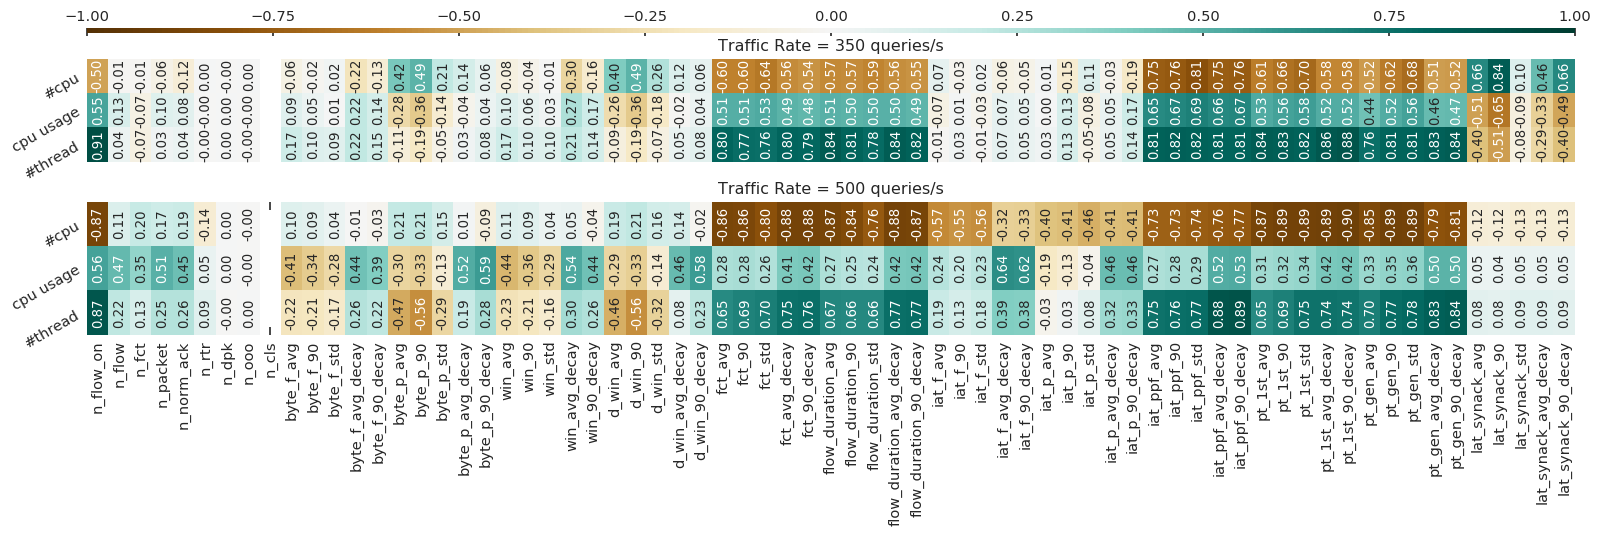

plot for trace PHP File


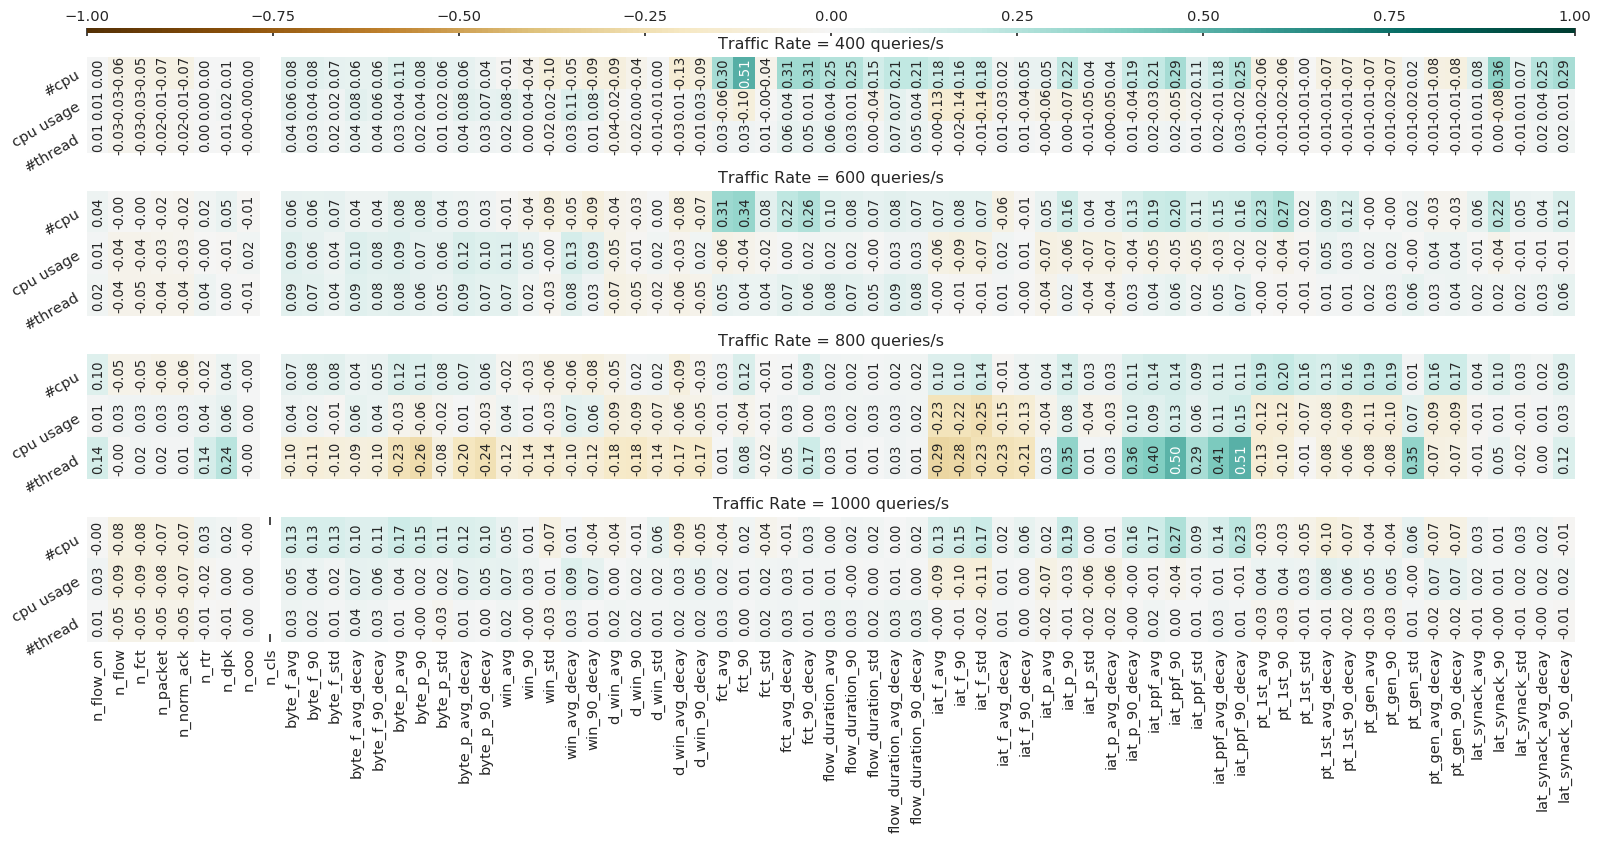

plot for trace Wiki


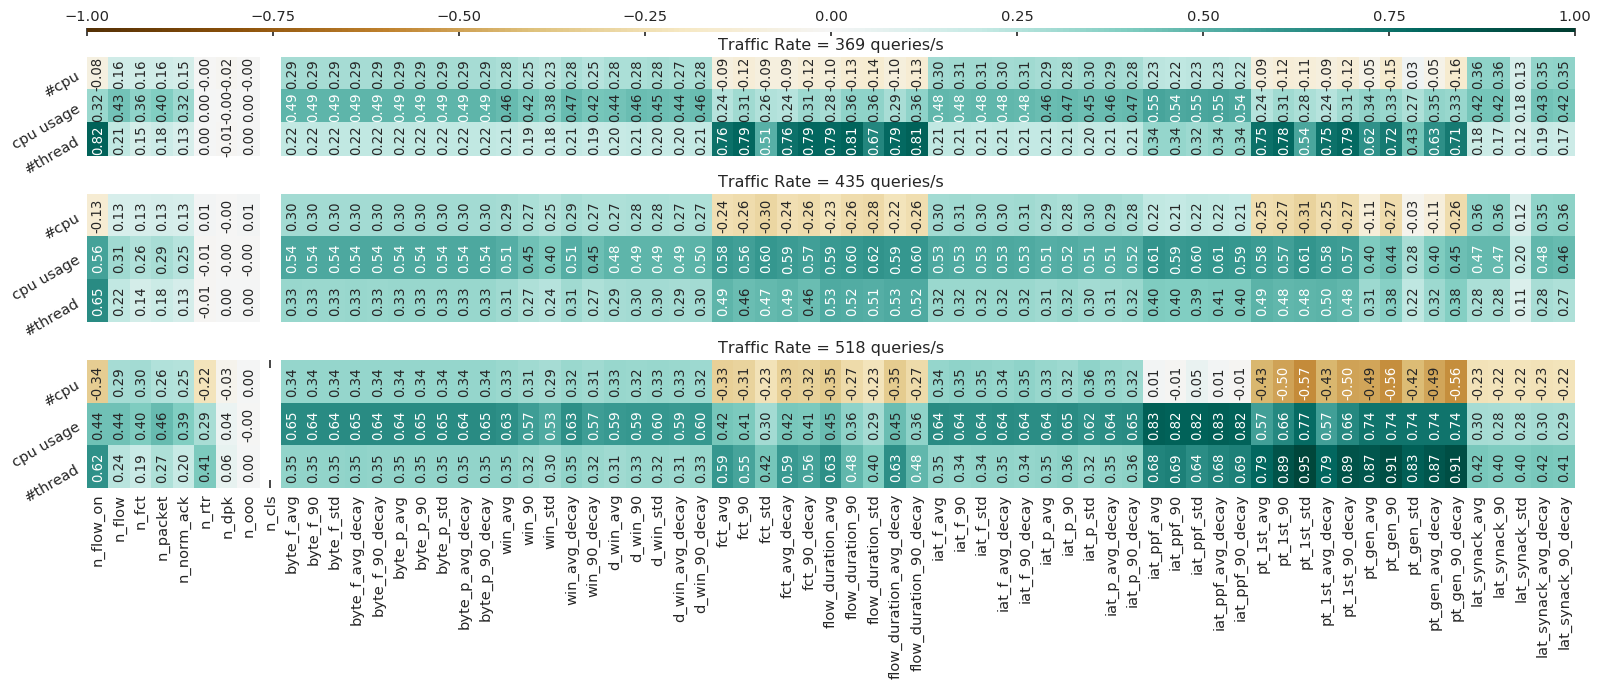

plot for trace Wiki (Flooded)


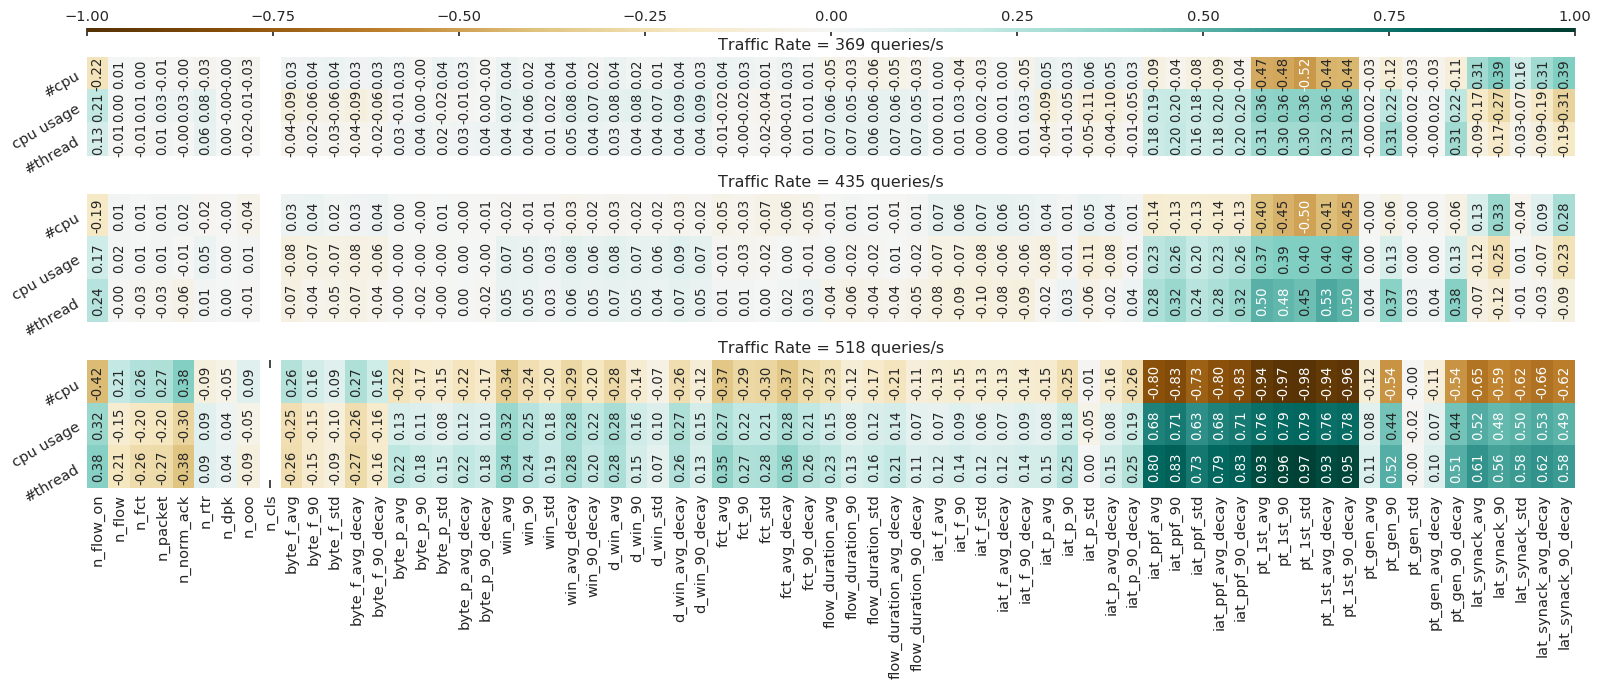

In [410]:
for trace in trace_types:
    plot_heatmap(trace)

## Timer

In [49]:
data = df_all.loc[df_all['Trace'] == 'Wiki (Flooded)', col2plot].values

In [35]:
data.shape

(6919, 69)

In [34]:
%%timeit
_ = scaler.transform(data)

1.6 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


-- PHP For-Loop --


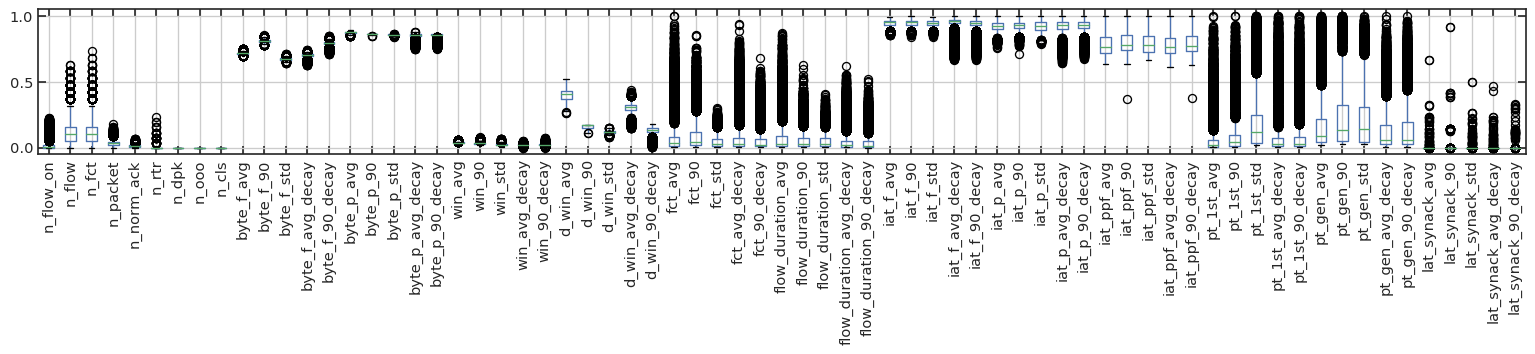

-- PHP File --


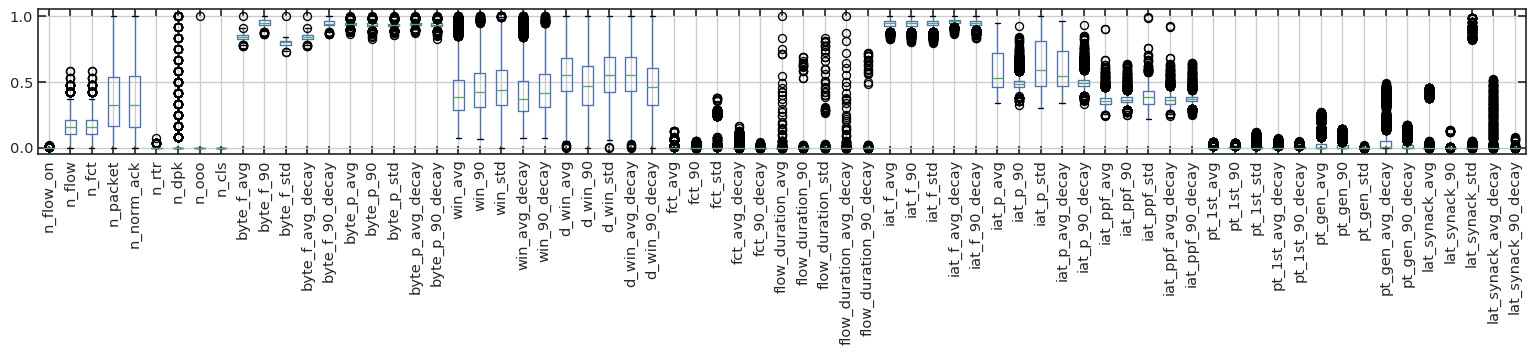

-- Wiki --


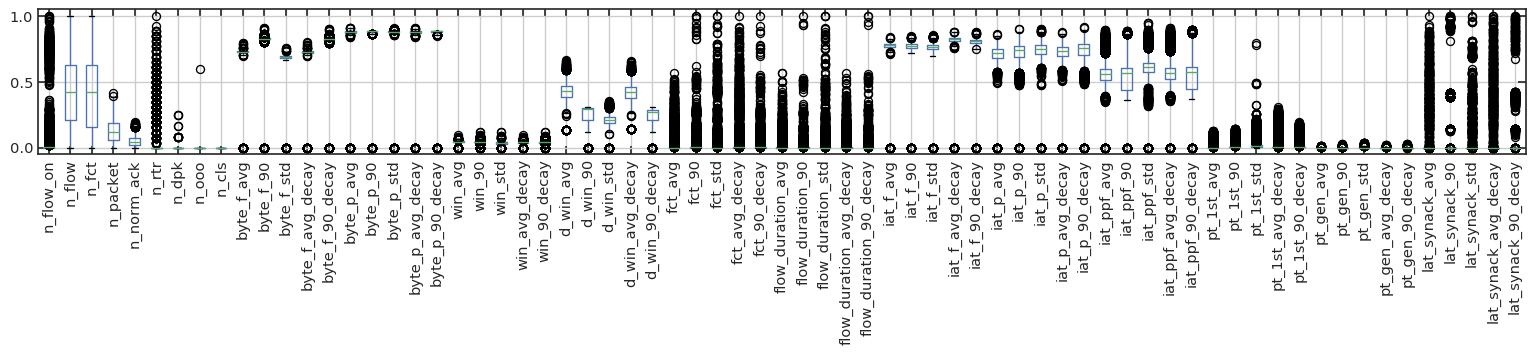

-- Wiki (Flooded) --


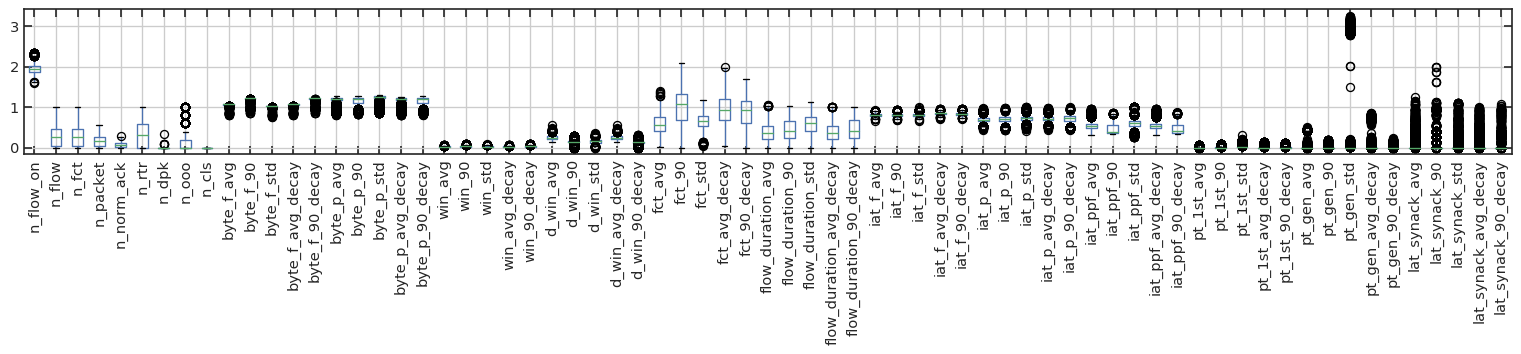

In [36]:
for trace in trace_types:
    print("-- {} --".format(trace))
    plt.figure(figsize=(20,2), dpi=96)
    df_all.loc[df_all['Trace'] == trace].boxplot(column=col2plot)
    plt.xticks(rotation=90)
    plt.show()

## PCA Analysis

In [644]:
def fit_pca(df_all, col2pca, n_components='mle'):
#     df_normal = df_all.loc[(df_all['memory']>0)&(df_all['Trace'] != 'Wiki (Flooded)')]
    df_normal = df_all.loc[(df_all['Trace'] != 'Wiki (Flooded)')]
    pca = PCA(n_components=n_components)
    pca.fit(df_normal[col2pca].values)
    return pca

def plot_pca(X_by_type, pca, scalex, scaley, t_fit, stride=15, figsize=(4, 3), xlim=[-1, 1], ylim=[-1, 1]):
    f = plt.figure(figsize=figsize, dpi=96)
    
    for trace, X in X_by_type.items():
        xs = X[::stride, 0]
        ys = X[::stride, 1]
        plt.plot(xs * scalex,ys * scaley, "w", linewidth=0.1, markeredgewidth=0.8, markerfacecolor=color_map[trace], marker=marker_map[trace], alpha=1.)
    for k, v in color_map.items():
        if 'Flood' in k:
            plt.plot([], [], "w", linewidth=0.1, markeredgewidth=0.8, markerfacecolor=v, marker=marker_map[k], label='Wiki (DoS)')
        else:
            plt.plot([], [], "w", linewidth=0.1, markeredgewidth=0.8, markerfacecolor=v, marker=marker_map[k], label=k)
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.text(xlim[0]+0.5*(xlim[1]-xlim[0]), ylim[0]+0.05*(ylim[1]-ylim[0]), "fit time: %.2fms" % (t_fit))



    plt.xlabel("PC{} (Explained Var. {:.0%})".format(1, pca.explained_variance_ratio_[0]))
    plt.ylabel("PC{} (Explained Var. {:.0%})".format(2, pca.explained_variance_ratio_[1]))
#     plt.legend(bbox_to_anchor=(0., 1.05, 1., .102), loc='lower left',
#                ncol=4, mode="expand", borderaxespad=0.)
    plt.legend()
    # plt.grid()
    plt.show()
    return f

def transform_pca(df_all, col2pca, pca):
#     all_data = df_all.loc[(df_all['memory']>0), col2pca].values
    all_data = df_all.loc[:, col2pca].values
    
    # get scale for pca plot
    x_min, x_max = all_data[:, 0].min(), all_data[:, 0].max()
    y_min, y_max = all_data[:, 1].min(), all_data[:, 1].max()
    scalex = 1.0/(x_max - x_min)
    scaley = 1.0/(y_max - y_min)
    
    X_by_type = {}
    for trace in trace_types:
        data = df_all.loc[df_all.Trace == trace, col2pca].values
        X_by_type[trace] = pca.transform(data)
        
    return X_by_type, pca, scalex, scaley
            
def plot_pca_contrib(pca, n_var=6, x_vert=3):
    f = plt.figure(figsize=(7,2), dpi=96)
    plt.bar(range(n_var), pca.explained_variance_ratio_[:n_var], color='#508fc3', width=0.5, label="Explained Variance")
    plt.plot(range(n_var), [sum(pca.explained_variance_ratio_[:i]) for i in range(1, n_var+1)], 'k-o', markersize=3, label="Cumulative Explained Variance")
    plt.plot(range(-2, n_var+2), [0.9]*(n_var+4), 'r', label='90% of the Variance')
    plt.plot([x_vert]*(2), range(0, 2), 'r')
    plt.ylabel('%')
    plt.xlabel('Principal Component')
    plt.legend()
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 20, 40, 60, 80, 100])
    plt.xticks(range(n_var), range(1, n_var+1))
    plt.xlim(-0.5, n_var-.5)
    plt.ylim(0, 1)
    plt.show()
    return f

def plot_pca_variables(pca, col2pca, n_var=6):
    f = plt.figure(figsize=(20,2), dpi=96)
    width=0.3
    n_var = len(col2pca)
    r = np.array(range(n_var))
    plt.bar(r-width/2, abs(pca.components_[0]), fill=False, edgecolor='#508fc3', hatch='//', width=width, label="PC1", linewidth=1)
    plt.bar(r+width/2, abs(pca.components_[1]), fill=False, edgecolor='r', hatch='..', width=width, label="PC2", linewidth=1)
    plt.bar(r+3*width/2, abs(pca.components_[2]), fill=False, edgecolor='g', hatch='xx', width=width, label="PC3", linewidth=1)
    pca_pc2_tuples = [(col, pca.components_[1][i]) for i, col in enumerate(col2pca)]
    plt.ylabel('Cosine Similarity (%)')
    plt.legend()
    plt.yticks([0, 0.1, 0.2, 0.3, 0.4], [0, 10, 20, 30, 40])
    plt.xticks(r, col2pca, rotation=90)
    plt.xlim(-0.5, n_var-.5)
    plt.show()
    return f

In [628]:
col2pca = [col for col in col2plot if col not in ['n_cls']]
df_all, scaler = get_preprocess_data(scaler_type='minmax')

pca = fit_pca(df_all, col2pca)

/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


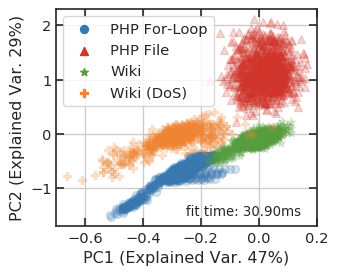

In [606]:
X_by_type, pca, scalex, scaley = transform_pca(df_all, col2pca, pca)

f = plot_pca(X_by_type, pca, scalex, scaley, 30.9, figsize=(3.5,3), xlim=[-0.7,0.2], ylim=[-1.7, 2.3])
f.savefig('../../data/figures/atc/application/classification/pca-full.pdf', bbox_inches='tight', transparent=True)

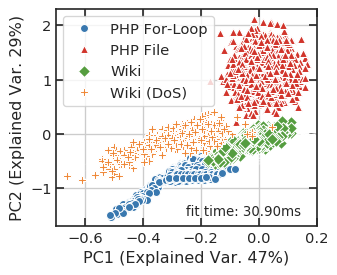

In [645]:
X_by_type, pca, scalex, scaley = transform_pca(df_all, col2pca, pca)

f = plot_pca(X_by_type, pca, scalex, scaley, 30.9, figsize=(3.5,3), xlim=[-0.7,0.2], ylim=[-1.7, 2.3])
f.savefig('../../data/figures/atc/application/classification/pca-full.pdf', bbox_inches='tight', transparent=True)

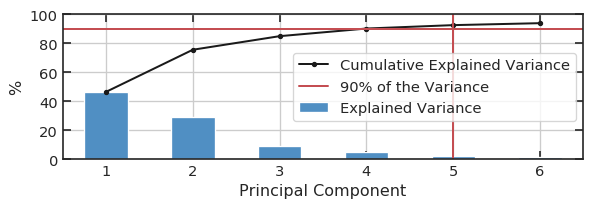

In [446]:
f = plot_pca_contrib(pca, n_var=6, x_vert=4)
f.savefig('../../data/figures/atc/application/classification/pca-pc.pdf', bbox_inches='tight', transparent=True)

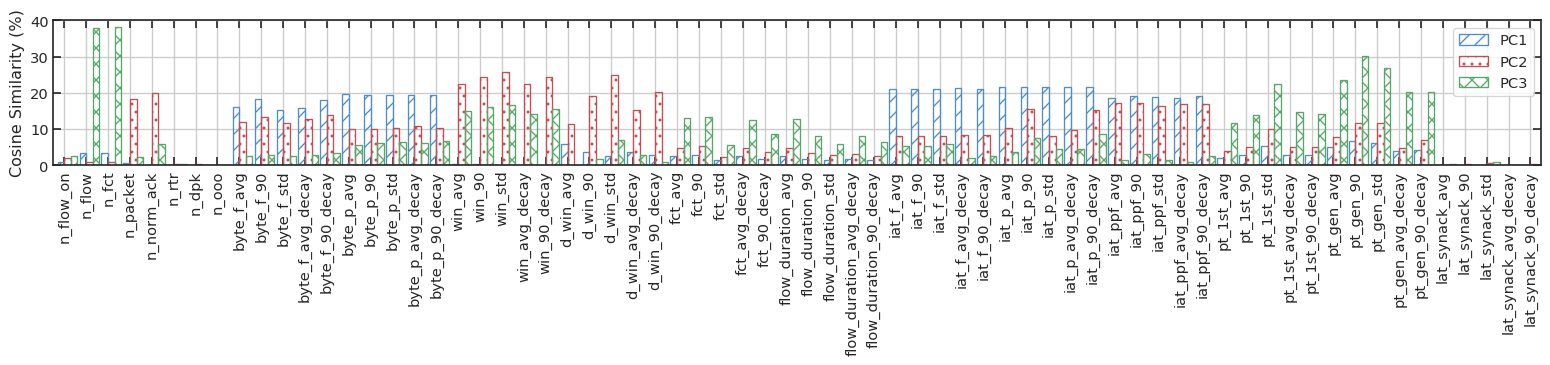

In [471]:
f = plot_pca_variables(pca, col2pca)
f.savefig('../../data/figures/atc/application/classification/pca-feature.pdf', bbox_inches='tight', transparent=True)

## Timer

In [584]:
data = df_all.loc[:, col2pca].values

In [585]:
%%timeit
_ = pca.transform(data)

5.37 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [476]:
%%timeit
_ = pca.transform(data)

30.9 ms ± 991 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [477]:
%%timeit
_ = pca.transform(data)

33.1 ms ± 3.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [478]:
%%timeit
_ = pca.transform(data)

31.6 ms ± 48.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [479]:
%%timeit
_ = pca.transform(data)

31.1 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [480]:
%%timeit
_ = pca.transform(data)

32.1 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [481]:
%%timeit
_ = pca.transform(data)

30.6 ms ± 488 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [482]:
%%timeit
_ = pca.transform(data)

31 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [483]:
%%timeit
_ = pca.transform(data)

30.6 ms ± 78 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [484]:
%%timeit
_ = pca.transform(data)

30.5 ms ± 75.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Use less features

In [619]:
cnt_cols

['n_flow_on', 'n_flow', 'n_fct', 'n_packet', 'n_rtr', 'n_dpk', 'n_ooo']

In [646]:
# cnt_cols = ['n_flow_on', 'n_flow', 'n_fct', 'n_packet', 'n_rtr', 'n_dpk', 'n_ooo']

col2reduce = [col for col in cols_all if col not in ['cpu usage', 'memory', '#thread', 'asid', '#cpu', 'Traffic Rate', 'Trace'] 
              and (
#                   ('_avg' in col and 'decay' not in col) # _avg
                  ('_avg' in col and 'decay' in col) # _avg_decay
#                   or ('_90' in col and 'decay' in col) # _90_decay
#                   or('_90' in col and 'decay' not in col) # _90
                  or ('_std' in col) # _std
              )
             ]

col2pca = [col for col in col2reduce if 'lat_' not in col and 'pt_' not in col] + cnt_cols

In [647]:
df_all, scaler = get_preprocess_data(scaler_type='minmax')

pca = fit_pca(df_all, col2pca)

/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/scipy/stats/stats.py:2281: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


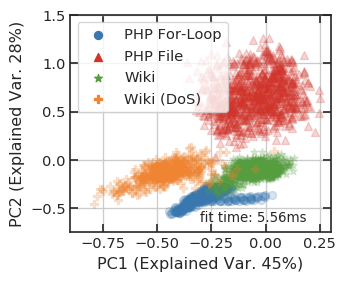

In [604]:
X_by_type, pca, scalex, scaley = transform_pca(df_all, col2pca, pca)

f = plot_pca(X_by_type, pca, scalex, scaley, 5.56, figsize=(3.5, 3), xlim=[-0.9, 0.3], ylim=[-0.75, 1.5])
f.savefig('../../data/figures/atc/application/classification/pca-partial.pdf', bbox_inches='tight', transparent=True)

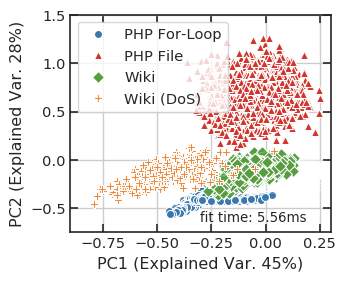

In [648]:
X_by_type, pca, scalex, scaley = transform_pca(df_all, col2pca, pca)

f = plot_pca(X_by_type, pca, scalex, scaley, 5.56, figsize=(3.5, 3), xlim=[-0.9, 0.3], ylim=[-0.75, 1.5])
f.savefig('../../data/figures/atc/application/classification/pca-partial.pdf', bbox_inches='tight', transparent=True)

In [598]:
data = df_all.loc[:, col2pca].values

In [172]:
data.shape

(62626, 25)

In [599]:
%%timeit
_ = pca.transform(data)

5.56 ms ± 46.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Clustering

In [654]:
X_by_type['Wiki'].shape

(22521, 24)

In [655]:
# Prepare data
np.random.seed(0)
stride = 15

n_clusters = len(trace_types)
X = [X_by_type[trace][::stride, :2] for trace in trace_types]
labels_true = [np.array([trace]*X_by_type[trace][::stride].shape[0]).reshape(-1, 1) for trace in trace_types]
labels_true_index = [np.array([i]*X_by_type[trace][::stride].shape[0]).reshape(-1, 1) for i,trace in enumerate(trace_types)]
X = np.vstack(X)
labels_true = np.vstack(labels_true)
labels_true_index = np.vstack(labels_true_index)

# remove outliers
xlim=[-0.8, 0.25]
ylim=[-0.65, 1.3]
x_max = xlim[1]

i_valid = [i for i in range(X.shape[0]) if X[i, 0] < x_max]
X = X[i_valid, :]
labels_true = labels_true[i_valid, :].reshape(-1)
labels_true_index = labels_true_index[i_valid, :].reshape(-1)

In [656]:
X.shape

(3973, 2)

## K-means

In [657]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn import metrics

In [658]:
# Compute clustering with Means
k_means = KMeans(init="k-means++", n_clusters=n_clusters
                 , n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

In [659]:
%%timeit
k_means.fit(X)

39.5 ms ± 963 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [660]:
# Compute clustering with MiniBatchKMeans
batch_size = 45

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=n_clusters,
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

In [493]:
%%timeit
mbk.fit(X)

62 ms ± 2.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [661]:
# Compute Spectral Clustering
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors',
                           assign_labels='discretize')
t0 = time.time()
spectral.fit(X)
t_spectral = time.time() - t0
spectral_labels = spectral.fit_predict(X)
# plt.scatter(X[:, 0], X[:, 1], c=labels,
#             s=50, cmap='viridis');

In [662]:
# Compute Spectral Clustering
gmm = mixture.GaussianMixture(
    n_components=params["n_clusters"], covariance_type="full"
)

t0 = time.time()
gmm.fit(X)
t_gmm = time.time() - t0
gmm_labels = gmm.fit_predict(X)
# plt.scatter(X[:, 0], X[:, 1], c=labels,
#             s=50, cmap='viridis');

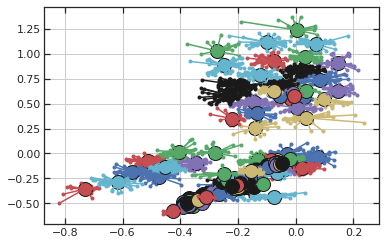

In [663]:
from itertools import cycle

plt.close("all")
plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

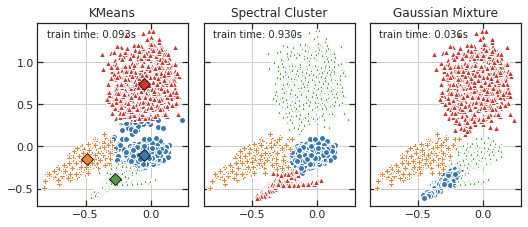

In [517]:
# Plot result

fig, axs = plt.subplots(1, 3, figsize=(7, 3), sharey=True)
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9, wspace=0.1)
colors = list(color_map.values())

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

markers = list(marker_map.values())

# KMeans
ax = axs[0]
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=markers[k])
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "D",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=8,
    )
ax.set_title("KMeans")
# ax.set_xticks(())
# ax.set_yticks(())
plt.sca(ax)
plt.text(xlim[0], ylim[1], "train time: %.3fs" % (t_batch))

# # MiniBatchKMeans
# ax = fig.add_subplot(1, 2, 2)
# for k, col in zip(range(n_clusters), colors):
#     my_members = mbk_means_labels == k
#     cluster_center = mbk_means_cluster_centers[k]
#     ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
#     ax.plot(
#         cluster_center[0],
#         cluster_center[1],
#         "o",
#         markerfacecolor=col,
#         markeredgecolor="k",
#         markersize=6,
#     )
# ax.set_title("MiniBatchKMeans")
# ax.set_xticks(())
# ax.set_yticks(())
# plt.text(xlim[0], ylim[1], "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))


# SpectralClustering
# ax = axs[1]
# for k, col in zip(range(n_clusters), colors):
#     my_members = spectral_labels == k
#     ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=markers[k])
# ax.set_title("Spectral Cluster")
# # ax.set_xticks(())
# # ax.set_yticks(())
# plt.sca(ax)
# plt.text(xlim[0], ylim[1], "train time: %.3fs" % (t_spectral))

# gmm
ax = axs[1]
for k, col in zip(range(n_clusters), colors):
    my_members = y_pred == k
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=markers[k])
ax.set_title("Gaussian Mixture")
# ax.set_xticks(())
# ax.set_yticks(())
plt.sca(ax)
plt.text(xlim[0], ylim[1], "train time: %.3fs" % (t_gmm))

# dbscan


# # Initialise the different array to all False
# different = mbk_means_labels == 4
# ax = fig.add_subplot(1, 4, 3)

# for k in range(n_clusters):
#     different += (k_means_labels == k) != (mbk_means_labels == k)

# identic = np.logical_not(different)
# ax.plot(X[identic, 0], X[identic, 1], "w", markerfacecolor="#bbbbbb", marker=".")
# ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
# ax.set_title("Difference")
# ax.set_xticks(())
# ax.set_yticks(())

# Actual cluster
# ax = fig.add_subplot(1, 3, 3)
# for k, col in zip(range(n_clusters), colors):
#     my_members = [i for i, v in enumerate(labels_true_index) if v== k]
# #     cluster_center = mbk_means_cluster_centers[k]
#     ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=markers[k])

# ax.set_title("Ground Truth")
# ax.set_xticks(())
# ax.set_yticks(())
# plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))

plt.show()
fig.savefig('../../data/figures/atc/application/classification/cluster-predict.pdf', bbox_inches='tight', transparent=True)

In [675]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============

stride = 15

n_clusters = len(trace_types)
X = [X_by_type[trace][::stride, :2] for trace in trace_types]
labels_true = [np.array([trace]*X_by_type[trace][::stride].shape[0]).reshape(-1, 1) for trace in trace_types]
labels_true_index = [np.array([i]*X_by_type[trace][::stride].shape[0]).reshape(-1, 1) for i,trace in enumerate(trace_types)]
X = np.vstack(X)
labels_true = np.vstack(labels_true)
labels_true_index = np.vstack(labels_true_index)

# remove outliers
xlim=[-0.8, 0.25]
ylim=[-0.65, 1.3]
x_max = xlim[1]

i_valid = [i for i in range(X.shape[0]) if X[i, 0] < x_max]
X = X[i_valid, :]
labels_true = labels_true[i_valid, :].reshape(-1)
labels_true_index = labels_true_index[i_valid, :].reshape(-1)

aquarius = X, labels_true

# ============
# Set up cluster parameters
# ============


default_base = {
    "quantile": 0.1,
    "eps": 0.1,
    "damping": 0.9,
    "preference": -240,
    "n_neighbors": 200,
    "n_clusters": 4,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.05,
}

In [676]:
# update parameters with dataset-specific values
params = default_base.copy()

X, y = aquarius

# normalize dataset for easier parameter selection

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params["n_neighbors"], include_self=False
)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = KMeans(init="k-means++", n_clusters=params["n_clusters"], n_init=10)
ward = cluster.AgglomerativeClustering(
    n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
)
spectral = cluster.SpectralClustering(
    n_clusters=params["n_clusters"],
    eigen_solver="arpack",
    affinity="nearest_neighbors",
)
dbscan = cluster.DBSCAN(eps=params['eps'], min_samples=100)
optics = cluster.OPTICS(
    min_samples=params["min_samples"],
    xi=params["xi"],
    min_cluster_size=params["min_cluster_size"],
)
affinity_propagation = cluster.AffinityPropagation(
    damping=params["damping"], preference=params["preference"]
)
average_linkage = cluster.AgglomerativeClustering(
    linkage="average",
    affinity="euclidean",
    n_clusters=params["n_clusters"],
    connectivity=connectivity,
)
birch = cluster.Birch(n_clusters=params["n_clusters"], threshold=0.15, branching_factor=500)
gmm = mixture.GaussianMixture(
    n_components=params["n_clusters"], covariance_type="full"
)

clustering_algorithms = (
    ("KMeans", two_means),
#     ("Affinity\nPropagation", affinity_propagation),
    ("MeanShift", ms),
    ("Spectral\nClustering", spectral),
    ("Ward", ward),
    ("Agglomerative\nClustering", average_linkage),
    ("DBSCAN", dbscan),
    ("OPTICS", optics),
    ("BIRCH", birch),
    ("Gaussian\nMixture", gmm),
)

Text(0.99, 0.01, '.03s')

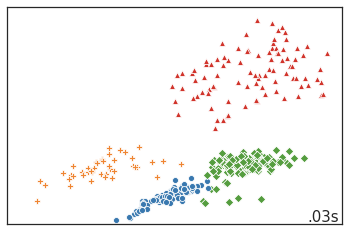

In [683]:
# add black color for outliers (if any)
colors = np.append(colors, ["#000000"])
for i in range(0, len(X), 10):
    plt.scatter(X[i, 0], X[i, 1], color=colors[y_pred[i]], marker=MARKERS[y_pred[i]], linewidth=0.8, edgecolor='w')

plt.xlim(xlim)
plt.ylim(ylim)
plt.xticks(())
plt.yticks(())
plt.text(
    0.99,
    0.01,
    ("%.2fs" % (t1 - t0)).lstrip("0"),
    transform=plt.gca().transAxes,
    size=15,
    horizontalalignment="right",
)

=== Method KMeans ===
Adjusted Rand Index: 0.914
Mutual Info Score: 1.180
Adjusted Mutual Info Score: 0.893
Homogeneity: 0.893
Completeness: 0.900
Fowlkes-Mallows Score: 0.938
Fit Time: 47.034ms


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


=== Method MeanShift ===
Adjusted Rand Index: 0.923
Mutual Info Score: 1.195
Adjusted Mutual Info Score: 0.904
Homogeneity: 0.904
Completeness: 0.910
Fowlkes-Mallows Score: 0.944
Fit Time: 681.866ms


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


=== Method Spectral
Clustering ===
Adjusted Rand Index: 0.957
Mutual Info Score: 1.244
Adjusted Mutual Info Score: 0.941
Homogeneity: 0.941
Completeness: 0.945
Fowlkes-Mallows Score: 0.969
Fit Time: 958.533ms


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


=== Method Ward ===
Adjusted Rand Index: 0.923
Mutual Info Score: 1.212
Adjusted Mutual Info Score: 0.916
Homogeneity: 0.917
Completeness: 0.919
Fowlkes-Mallows Score: 0.945
Fit Time: 5871.500ms


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


=== Method Agglomerative
Clustering ===
Adjusted Rand Index: 0.351
Mutual Info Score: 0.574
Adjusted Mutual Info Score: 0.434
Homogeneity: 0.434
Completeness: 0.814
Fowlkes-Mallows Score: 0.644
Fit Time: 4020.033ms


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


=== Method DBSCAN ===
Adjusted Rand Index: 0.477
Mutual Info Score: 0.775
Adjusted Mutual Info Score: 0.586
Homogeneity: 0.586
Completeness: 0.760
Fowlkes-Mallows Score: 0.682
Fit Time: 89.931ms


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


=== Method OPTICS ===
Adjusted Rand Index: 0.881
Mutual Info Score: 1.133
Adjusted Mutual Info Score: 0.857
Homogeneity: 0.857
Completeness: 0.875
Fowlkes-Mallows Score: 0.915
Fit Time: 3902.474ms


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


=== Method BIRCH ===
Adjusted Rand Index: 0.515
Mutual Info Score: 0.839
Adjusted Mutual Info Score: 0.634
Homogeneity: 0.635
Completeness: 0.847
Fowlkes-Mallows Score: 0.709
Fit Time: 88.208ms


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


=== Method Gaussian
Mixture ===
Adjusted Rand Index: 0.923
Mutual Info Score: 1.200
Adjusted Mutual Info Score: 0.908
Homogeneity: 0.908
Completeness: 0.910
Fowlkes-Mallows Score: 0.944
Fit Time: 23.180ms


/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


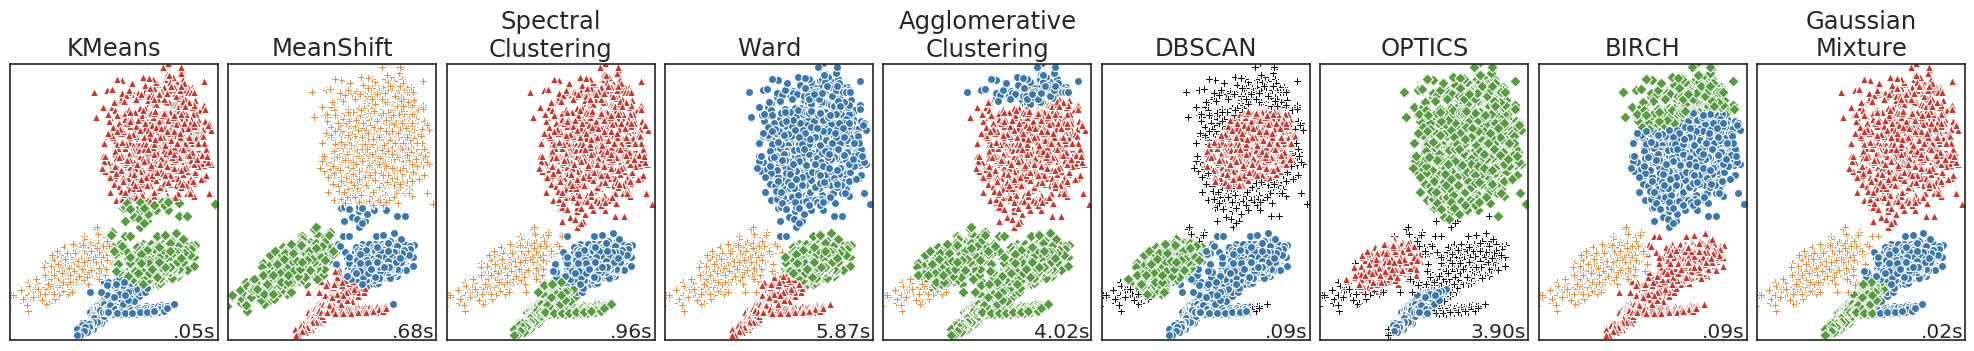

In [684]:
predictions = {}
fit_times = {}


plot_num = 1
fig = plt.figure(figsize=(9 * 2 + 3, 3), dpi=97)
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)


for name, algorithm in clustering_algorithms:
    t0 = time.time()
    print("=== Method {} ===".format(name))

#     catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the "
            + "connectivity matrix is [0-9]{1,2}"
            + " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning,
        )
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding"
            + " may not work as expected.",
            category=UserWarning,
        )
        algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, "labels_"):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)
    predictions[name] = y_pred
    fit_times[name] = t1 - t0
    
    # evaluation
    print("Adjusted Rand Index: {:.3f}".format(metrics.adjusted_rand_score(labels_true_index, y_pred)))    
    print("Mutual Info Score: {:.3f}".format(metrics.mutual_info_score(labels_true_index, y_pred)))
    print("Adjusted Mutual Info Score: {:.3f}".format(metrics.adjusted_mutual_info_score(labels_true_index, y_pred)))    
    print("Homogeneity: {:.3f}".format(metrics.homogeneity_score(labels_true_index, y_pred)))    
    print("Completeness: {:.3f}".format(metrics.completeness_score(labels_true_index, y_pred)))    
    print("Fowlkes-Mallows Score: {:.3f}".format(metrics.fowlkes_mallows_score(labels_true_index, y_pred)))    
    print("Fit Time: {:.3f}ms".format(1000*(t1-t0)))

    plt.subplot(1, len(clustering_algorithms), plot_num)

    plt.title(name, size=18)

    colors = np.array(
        list(
            islice(
                cycle(
                    list(color_map.values())
#                     [
#                         "#377eb8",
#                         "#ff7f00",
#                         "#4daf4a",
#                         "#f781bf",
#                         "#a65628",
#                         "#984ea3",
#                         "#999999",
#                         "#e41a1c",
#                         "#dede00",
#                     ]
                ),
                int(max(y_pred) + 1),
            )
        )
    )
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    for i in range(len(X)):
        plt.scatter(X[i, 0], X[i, 1], color=colors[y_pred[i]], marker=MARKERS[y_pred[i]], linewidth=0.8, edgecolor='w')

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks(())
    plt.yticks(())
    plt.text(
        0.99,
        0.01,
        ("%.2fs" % (t1 - t0)).lstrip("0"),
        transform=plt.gca().transAxes,
        size=15,
        horizontalalignment="right",
    )
    plot_num += 1

plt.show()
fig.savefig('../../data/figures/atc/application/classification/cluster-predict-all.pdf', bbox_inches='tight', transparent=True)

In [685]:
fig.savefig('../../data/figures/atc/application/classification/cluster-predict-all.pdf', bbox_inches='tight', transparent=True)

In [669]:
clustering_algorithms = (
    ("KMeans", two_means),
    ("Gaussian\nMixture", gmm),
    ("DBSCAN", dbscan),
)

In [670]:
from scipy import linalg
import matplotlib as mpl

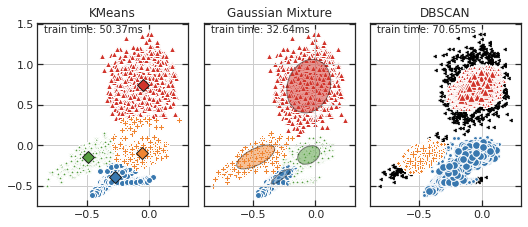

In [618]:
# Plot selected result
ylim = [-0.75, 1.5]
xlim = [-0.9, 0.3]


fig, axs = plt.subplots(1, 3, figsize=(7, 3), sharey=True, sharex=True)
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9, wspace=0.1)
colors = list(color_map.values())

markers = list(marker_map.values())

# KMeans
method = 'KMeans'
ax = axs[0]
for k, col in zip(range(n_clusters), colors):
    my_members = predictions[method] == k
    cluster_center = two_means.cluster_centers_[k]
    ax.scatter(X[my_members, 0], X[my_members, 1], color=col, edgecolor='w', marker=markers[k])
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "D",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=8,
    )
ax.set_title(method)
# ax.set_xticks(())
# ax.set_yticks(())
plt.sca(ax)
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[0]+0.95*(ylim[1]-ylim[0]), "train time: %.2fms" % (fit_times[method]*1000))

# gmm
method = "Gaussian\nMixture"

ax = axs[1]

for k, col, mean, covar in zip(range(n_clusters), colors, gmm.means_, gmm.covariances_):
    my_members = predictions[method] == k
    v, w = linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, facecolor=col, edgecolor='k', zorder=1)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_patch(ell)
#     ax.set_xlim([-2, 1])
    ax.scatter(X[my_members, 0], X[my_members, 1], color=col, edgecolor='w', alpha=1, marker=markers[k], zorder=0)
    
ax.set_title("Gaussian Mixture")
plt.sca(ax)
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[0]+0.95*(ylim[1]-ylim[0]), "train time: %.2fms" % (fit_times[method]*1000))

# dbscan
ax = axs[2]
method = "DBSCAN"

core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

markers += ['3']
for k, col in zip(range(-1, n_clusters), ['#000000']+colors):
    my_members = predictions[method] == k
    if k == 2: 
        k = 3
        col = colors[k]
    ax.scatter(X[my_members & ~core_samples_mask, 0], X[my_members & ~core_samples_mask, 1], marker=markers[k], color=col, edgecolor='w', s=15)
    ax.scatter(X[my_members & core_samples_mask, 0], X[my_members & core_samples_mask, 1], marker=markers[k], color=col, edgecolor='w', s=60)


ax.set_title(method)
# ax.set_xticks(())
# ax.set_yticks(())
plt.sca(ax)
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[0]+0.95*(ylim[1]-ylim[0]), "train time: %.2fms" % (fit_times[method]*1000))



plt.show()
fig.savefig('../../data/figures/atc/application/classification/cluster-predict.pdf', bbox_inches='tight', transparent=True)

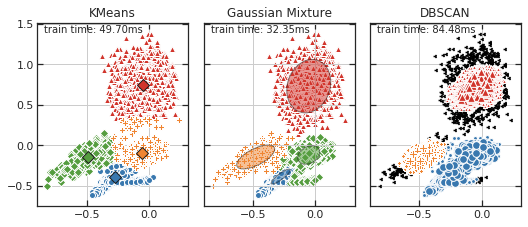

In [671]:
# Plot selected result
ylim = [-0.75, 1.5]
xlim = [-0.9, 0.3]


fig, axs = plt.subplots(1, 3, figsize=(7, 3), sharey=True, sharex=True)
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9, wspace=0.1)
colors = list(color_map.values())

markers = list(marker_map.values())

# KMeans
method = 'KMeans'
ax = axs[0]
for k, col in zip(range(n_clusters), colors):
    my_members = predictions[method] == k
    cluster_center = two_means.cluster_centers_[k]
    ax.scatter(X[my_members, 0], X[my_members, 1], color=col, edgecolor='w', marker=markers[k])
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "D",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=8,
    )
ax.set_title(method)
# ax.set_xticks(())
# ax.set_yticks(())
plt.sca(ax)
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[0]+0.95*(ylim[1]-ylim[0]), "train time: %.2fms" % (fit_times[method]*1000))

# gmm
method = "Gaussian\nMixture"

ax = axs[1]

for k, col, mean, covar in zip(range(n_clusters), colors, gmm.means_, gmm.covariances_):
    my_members = predictions[method] == k
    v, w = linalg.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, facecolor=col, edgecolor='k', zorder=1)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_patch(ell)
#     ax.set_xlim([-2, 1])
    ax.scatter(X[my_members, 0], X[my_members, 1], color=col, edgecolor='w', alpha=1, marker=markers[k], zorder=0)
    
ax.set_title("Gaussian Mixture")
plt.sca(ax)
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[0]+0.95*(ylim[1]-ylim[0]), "train time: %.2fms" % (fit_times[method]*1000))

# dbscan
ax = axs[2]
method = "DBSCAN"

core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

markers += ['3']
for k, col in zip(range(-1, n_clusters), ['#000000']+colors):
    my_members = predictions[method] == k
    if k == 2: 
        k = 3
        col = colors[k]
    ax.scatter(X[my_members & ~core_samples_mask, 0], X[my_members & ~core_samples_mask, 1], marker=markers[k], color=col, edgecolor='w', s=15)
    ax.scatter(X[my_members & core_samples_mask, 0], X[my_members & core_samples_mask, 1], marker=markers[k], color=col, edgecolor='w', s=60)


ax.set_title(method)
# ax.set_xticks(())
# ax.set_yticks(())
plt.sca(ax)
plt.text(xlim[0]+0.05*(xlim[1]-xlim[0]), ylim[0]+0.95*(ylim[1]-ylim[0]), "train time: %.2fms" % (fit_times[method]*1000))



plt.show()
fig.savefig('../../data/figures/atc/application/classification/cluster-predict.pdf', bbox_inches='tight', transparent=True)

In [622]:
col2pca

['byte_f_std',
 'byte_f_avg_decay',
 'byte_p_std',
 'byte_p_avg_decay',
 'win_std',
 'win_avg_decay',
 'd_win_std',
 'd_win_avg_decay',
 'fct_std',
 'fct_avg_decay',
 'flow_duration_std',
 'flow_duration_avg_decay',
 'iat_f_std',
 'iat_f_avg_decay',
 'iat_p_std',
 'iat_p_avg_decay',
 'iat_ppf_std',
 'iat_ppf_avg_decay',
 'n_flow_on',
 'n_flow',
 'n_fct',
 'n_packet',
 'n_rtr',
 'n_dpk',
 'n_ooo']